> And the whole question of reinforcement learning is how can we get this ultimate reward that we will get and propagate it back and learned how to behave.                            
--MITx_6.86x

# 前言

## 强化学习基础篇

### 1. 初探强化学习

### 2. 多臂老虎机

#### 2.2. 问题介绍

实现一个拉杆数为 10 的多臂老虎机。其中拉动每根拉杆的奖励服从伯努利分布（Bernoulli distribution），即每次拉下拉杆有的概率获得的奖励为 1，有的概率获得的奖励为 0。奖励为 1 代表获奖，奖励为 0 代表没有获奖。

In [1]:

# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """

    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        if np.random.rand() < self.probs[k]:  ## 依概率self.probs[k]返回的奖励1
            return 1
        else:
            return 0  ## 依概率1 - self.probs[k]返回的奖励0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print(f'随机生成了一个{K}臂伯努利老虎机')
print(f'获奖概率最大的拉杆为{bandit_10_arm.best_idx}号,其获奖概率为{bandit_10_arm.best_prob:.4f}')

# 随机生成了一个10臂伯努利老虎机
# 获奖概率最大的拉杆为1号,其获奖概率为0.7203

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


用一个 Solver 基础类来实现上述的多臂老虎机的求解方案。

In [2]:
class Solver:
    """ 多臂老虎机算法基本框架 """

    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()  ## 根据策略选择拉杆，然后拉动拉杆，算拉杆奖励的期望值
            self.counts[k] += 1  ## 拉动拉杆的次数+1
            self.actions.append(k)  ## 记录每一步的动作action，也就是拉动的拉杆标号
            self.update_regret(k)  ## 更新懊悔地累加值

#### 2.3. Exploration and Exploitation

##### 2.3.1. Epsilon-Greedy

每次以概率 $\epsilon$ 选择随机动作，以概率 $1-\epsilon$ 选择当前最优动作。

estimates增量更新推导：
$$
\begin{align*}
Q_{n+1} &= \frac{1}{n+1} \sum_{i=1}^{n+1} r_{i} \\
     &= \frac{1}{n+1} (r_{n+1} + \sum_{i=1}^{n} r_{i})\\
        &= \frac{1}{n+1} (r_{n+1} + (n) \frac{1}{n} \sum_{i=1}^{n} r_{i})\\
        &= \frac{1}{n+1} (r_{n+1} + (n) Q_{n})\\
        &= Q_{n} + \frac{1}{n+1} (r_{n+1} - Q_{n})
\end{align*}
$$


In [3]:
class EpsilonGreedy(Solver):
    """ 
    epsilon贪婪算法,继承Solver类 
    T随机，R随机
    """

    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆，在0到K之间，左闭右开
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 算第K根拉杆的期望奖励，增量更新的
        return k

直观地展示，可以把每一时间步的累积函数绘制出来

In [4]:
def plot_results(solvers, solver_names):
    """
    生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称
    """
    for idx, solver in enumerate(solvers):  ## 遍历所有的解决方案，实际上只有一个解决方案
        time_list = range(len(solver.regrets))  ## 每一步的懊悔记录，拿到横轴的数值
        plt.plot(time_list, solver.regrets, label=solver_names[idx])  # 绘制，横轴是时间步，纵轴是懊悔值
    plt.xlabel('Time steps')  ##  横轴的标签
    plt.ylabel('Cumulative regrets')  ##  纵轴的标签
    plt.title(f'{solvers[0].bandit.K}-armed bandit')  ##  标题
    plt.legend()  ##  图例
    plt.show()  ##  显示图片的


np.random.seed(1)  ## 初始化随机数的 seed 种子
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm)  ## 策略器初始化
epsilon_greedy_solver.run(5000)  ## 拉动拉杆共五千次，然后运算累加懊悔，每个杆的期望奖励等
print(f'epsilon-贪婪算法的累积懊悔为：{epsilon_greedy_solver.regret}')
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# epsilon-贪婪算法的累积懊悔为：25.526630933945313

epsilon-贪婪算法的累积懊悔为：25.526630933945313


NameError: name 'plt' is not defined

In [ ]:
# 绘制概率图
def plot_estimates(bandit, solver):
    x = range(bandit.K)
    plt.plot(x, solver.estimates, alpha=0.6, label='estimates')
    plt.plot(x, bandit.probs, alpha=0.6, label='real probs')
    plt.xlabel('Action')
    plt.ylabel('Value')
    plt.title('Estimates and real probabilities')
    plt.legend()
    for i in range(bandit.K):
        plt.text(i, bandit.probs[i], f'{bandit.probs[i]:.2f}', ha='center', va='bottom')
        plt.text(i, solver.estimates[i], f'{solver.estimates[i]:.2f}', ha='center', va='top')
    plt.show()


plot_estimates(bandit_10_arm, epsilon_greedy_solver)

尝试不同的参数 $\epsilon$，并比较不同参数下的累积懊悔值。

In [ ]:
np.random.seed(0)  ## 给定随机种子，保证实验可以复现
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]  ## 不同的ε值
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons  ## 初始化不同的策略解决方案
]
epsilon_greedy_solver_names = [f"epsilon={e}" for e in epsilons]  ## 不同ε值对应的名称
for solver in epsilon_greedy_solver_list:  ## 遍历策略解决方案，每个策略运行五千次
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)  ## 绘制图像的

尝试$\epsilon$值随时间反比例衰减的策略，即 $\epsilon = \frac{1}{t}$。

In [ ]:
class DecayingEpsilonGreedy(Solver):
    """ 
    epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 
    """

    def __init__(self, bandit, init_prob=1.0):
        super().__init__(bandit)  ## 初始化基类Solver
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励，=1
        self.total_count = 0  ## 拉杆的总次数

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        self.total_count += 1  ## 拉杆的次数+1，此时ε=拉杆次数的倒数，拉杆次数越多ε越小
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)  ## 此时有ε的概率随机选择拉杆
        else:
            k = np.argmax(self.estimates)  ## 此时有1-ε的概率选择期望奖励最大的拉杆

        r = self.bandit.step(k)  ## 获得第k根拉杆的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新期望奖励

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)  ## 初始化延迟策略解决方案
decaying_epsilon_greedy_solver.run(5000)  ## 运行五千次拉杆操作的
print(f'epsilon值衰减的贪婪算法的累积懊悔为：{decaying_epsilon_greedy_solver.regret}')
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])  ## 绘制图像的

In [ ]:
# 绘制概率图
plot_estimates(bandit_10_arm, decaying_epsilon_greedy_solver)

##### 2.3.2. Upper Confidence Bound (UCB)上置信界算法

霍夫丁不等式（Hoeffding's inequality）
$$
\begin{align*}
P(E(x) \geq \bar{x}_n + \epsilon) \leq e^{-2n\epsilon^2} &= p\\
\ln p &= -2n\epsilon^2\\
\epsilon &= \sqrt{\frac{-\ln p}{2n}}
\end{align*}
$$
即 $Q_t(a)$ 以$1-p$的概率 $< \hat{Q}_t(a) + \sqrt{\frac{-\ln p}{2n}}$。

令 $p = \frac{1}{t}$，则 $\epsilon = \sqrt{\frac{\ln t}{2n}}$。

为避免除数为0，为每根拉杆的尝试次数加上1，即 $\epsilon = \sqrt{\frac{\ln t}{2(n+1)}}$。

设定一个系数c来控制不确定性的比重，即 $Q_t(a) = \hat{Q}_t(a) + c\sqrt{\frac{\ln t}{2(n+1)}}$。

In [ ]:
class UCB(Solver):
    """ 
    UCB算法,继承Solver类 
    T选π，R随机
    """

    def __init__(self, bandit, coef, init_prob=1.0):  ##  初始化ucb类的
        super().__init__(bandit)  ##  初始化基类Solver
        self.total_count = 0  ##  总的拉杆次数
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励
        self.coef = coef  ## ucb的权重

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        self.total_count += 1  ##  运行的总次数+1

        ## 算出所有拉杆的期望奖励上界
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆(期望奖励上界最大的动作)
        r = self.bandit.step(k)  ## 拿到奖励的数值
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新对应拉杆的期望奖励
        return k


np.random.seed(1)  ## 给定随机数种子，方便复现的
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)  ## 实例化ucb类的
UCB_solver.run(5000)  ## 共拉杆五千次
print(f'上置信界算法的累积懊悔为：{UCB_solver.regret}')
plot_results([UCB_solver], ["UCB"])  ## 绘制图像的

# 上置信界算法的累积懊悔为： 70.45281214197854

In [ ]:
# 绘制概率图
plot_estimates(bandit_10_arm, UCB_solver)

##### 2.3.3. Thompson Sampling

假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来进行选择。

通常用 Beta 分布对当前每个动作的奖励概率分布进行建模。具体来说，若某拉杆被选择了 $k$ 次，其中$m_1$次获奖，$m_0$次未获奖，则该拉杆的奖励概率服从参数为$(m_1+1, m_0+1)$的 Beta 分布。

In [ ]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """

    def __init__(self, bandit):
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        super().run(num_steps)
        # 完成后使用Beta分布的期望值来估计每根拉杆的获奖概率
        self.estimates = self._a / (self._a + self._b)


np.random.seed(1)  ## 给定随机数种子，方便复现的
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)  ## 实例化Thompson类的
thompson_sampling_solver.run(5000)  ## 共拉杆五千次
print(f'汤普森采样算法的累积懊悔为：{thompson_sampling_solver.regret}')
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

# 汤普森采样算法的累积懊悔为：57.19161964443925

In [ ]:
# 绘制概率图
plot_estimates(bandit_10_arm, thompson_sampling_solver)

### 3. 马尔可夫决策过程

> Markov decision processes are an extension of Markov chains; the difference is the addition of actions (allowing choice) and rewards (giving motivation). Conversely, if only one **a**ction exists for each state (e.g. “wait”) and all **r**ewards are the same (e.g. “zero”), a Markov decision process reduces to a Markov chain.”

#### 3.3. Utility Function

- why not finite horizon utility?

if you just go one step to go, you may go to extremely risky behaviour because you have no other chances.

- The main problem for MDPs is to optimize the agent’s behavior. To do so, **we first need to specify the criterion that we are trying to maximize in terms of accumulated rewards.**

$ U \leq \frac{R_{max}}{1-\lambda}  $

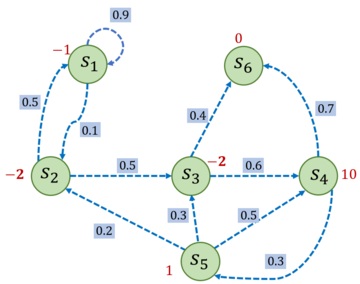

s1-s2-s3-s6

In [ ]:
import numpy as np

np.random.seed(0)
# 定义状态转移概率矩阵T
T = [
    [0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
    [0.0, 0.2, 0.3, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
T = np.array(T)

rewards = [-1, -2, -2, 10, 1, 0]  # 定义奖励函数
gamma = 0.5  # 定义折扣因子
# chain：序列
# gamma：折扣因子
# 给定一条序列,计算从某个索引（起始状态）开始到序列最后（终止状态）得到的回报
from copy import deepcopy


def compute_return(start_index, chain, gamma):
    G = 0
    ret = []
    for i in reversed(range(start_index, len(chain))):  ## 运算的方向要倒着来
        g_ = deepcopy(G)
        G = gamma * G + rewards[chain[i] - 1]  ## 从后往前依次运算求出结果
        ret.append([G, gamma, g_, rewards[chain[i] - 1], chain[i]])  ## 保存
    '''
    https://zhuanlan.zhihu.com/p/655615836
     0.0 = 0.5 *  0     +   0         6
    -2.0 = 0.5 *  0     +  -2         6->3
    -3.0 = 0.5 * -2.0   +  -2         3->2
    -2.5 = 0.5 * -3.0   +  -1         2->1
   ret=    [[ 0.0, 0.5,  0,    0, 6], 
            [-2.0, 0.5,  0.0, -2, 3], 
            [-3.0, 0.5, -2.0, -2, 2], 
            [-2.5, 0.5, -3.0, -1, 1]]
    '''
    return G


# 一个状态序列,s1-s2-s3-s6
chain = [1, 2, 3, 6]
start_index = 0
G = compute_return(start_index, chain, gamma)
print(f'根据本序列计算得到回报为：{G}')

# 根据本序列计算得到回报为：-2.5。

##### 3.3.2. Value Function

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

Value Function使用Bellman equation的解析解
$$
\begin{align*}
V &= R + \gamma TV \\
(I - \gamma T) V &= R \\
V &= (I - \gamma T)^{-1} R 
\end{align*}
$$

In [ ]:
def compute(T, rewards, gamma, states_num):
    ''' 利用贝尔曼方程的矩阵形式计算解析解,states_num是MRP的状态数 '''
    rewards = np.array(rewards).reshape((-1, 1))  #将rewards写成列向量形式    ## r：每个状态的奖励值
    ## 对应求解析解的公式，V=(1-γP)^(-1)r
    # value = np.dot(np.linalg.inv(np.eye(states_num, states_num) - gamma * T), rewards)
    value = np.asmatrix(np.eye(states_num) - gamma * T).I @ rewards

    return value


V = compute(T, rewards, gamma, 6)
print("MRP中每个状态价值分别为\n", V)

# MRP中每个状态价值分别为
#  [[-2.01950168]
#  [-2.21451846]
#  [ 1.16142785]
#  [10.53809283]
#  [ 3.58728554]
#  [ 0.        ]]

#### 3.4. 马尔可夫决策过程（Markov decision process，MDP）

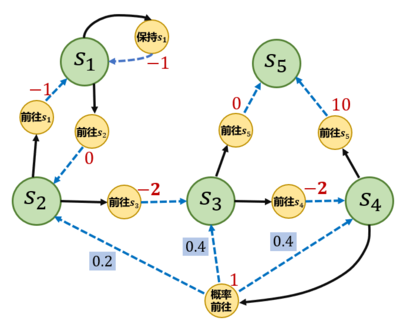

##### 3.4.2. Q-value Function 动作价值函数 action-value function

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

In [ ]:
S = ["s1", "s2", "s3", "s4", "s5"]  # 状态集合
A = ["保持s1", "前往s1", "前往s2", "前往s3", "前往s4", "前往s5", "概率前往"]  # 动作集合
# 状态转移函数
T = {
    "s1-保持s1-s1": 1.0,
    "s1-前往s2-s2": 1.0,
    "s2-前往s1-s1": 1.0,
    "s2-前往s3-s3": 1.0,
    "s3-前往s4-s4": 1.0,
    "s3-前往s5-s5": 1.0,
    "s4-前往s5-s5": 1.0,
    "s4-概率前往-s2": 0.2,
    "s4-概率前往-s3": 0.4,
    "s4-概率前往-s4": 0.4,
}
# 奖励函数
R = {
    "s1-保持s1": -1,
    "s1-前往s2": 0,
    "s2-前往s1": -1,
    "s2-前往s3": -2,
    "s3-前往s4": -2,
    "s3-前往s5": 0,
    "s4-前往s5": 10,
    "s4-概率前往": 1,
}
gamma = 0.5  # 折扣因子
MDP = (S, A, T, R, gamma)

# 策略π1,随机策略
pi_1 = {
    "s1-保持s1": 0.5,
    "s1-前往s2": 0.5,
    "s2-前往s1": 0.5,
    "s2-前往s3": 0.5,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.5,
    "s4-概率前往": 0.5,
}
# 策略π2
pi_2 = {
    "s1-保持s1": 0.6,
    "s1-前往s2": 0.4,
    "s2-前往s1": 0.3,
    "s2-前往s3": 0.7,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.1,
    "s4-概率前往": 0.9,
}


# 把输入的两个字符串通过“-”连接,便于使用上述定义的T、R变量
def join(str1, str2):
    return str1 + '-' + str2

转化后的 MRP 的状态转移矩阵和奖励函数

In [5]:
gamma = 0.5
# 转化后的MRP的状态转移矩阵
T_from_mdp_to_mrp = [
    [0.5, 0.5, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.5, 0.5],
    [0.0, 0.1, 0.2, 0.2, 0.5],
    [0.0, 0.0, 0.0, 0.0, 1.0],
]
'''
T(1|1) = pi_1["s1-保持s1"] * T["s1-保持s1-s1"] = 1 * 0.5 = 0.5
T(2|1) = pi_1["s1-前往s2"] * T["s1-前往s2-s2"] = 1 * 0.5 = 0.5
T(1|2) = pi_1["s2-前往s1"] * T["s2-前往s1-s1"] = 1 * 0.5 = 0.5
T(3|2) = pi_1["s2-前往s3"] * T["s2-前往s3-s3"] = 1 * 0.5 = 0.5
T(4|3) = pi_1["s3-前往s4"] * T["s3-前往s4-s4"] = 1 * 0.5 = 0.5
T(5|3) = pi_1["s3-前往s5"] * T["s3-前往s5-s5"] = 1 * 0.5 = 0.5
T(2|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s2"] = 0.5 * 0.2 = 0.1
T(3|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s3"] = 0.5 * 0.4 = 0.2
T(4|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s4"] = 0.5 * 0.4 = 0.2
T(5|4) = pi_1["s4-前往s5"] * T["s4-前往s5-s5"] = 0.5 * 1 = 0.5
T(5|5) = 1
'''
T_from_mdp_to_mrp = np.array(T_from_mdp_to_mrp)
R_from_mdp_to_mrp = [-0.5, -1.5, -1.0, 5.5, 0]  ## MDP转MRP以后的状态奖励
'''
r(s1) = pi_1["s1-保持s1"] * R["s1-保持s1"] + pi_1["s1-前往s2"] * R["s1-前往s2"] = -1 * 0.5 + 0 * 0.5 = -0.5
r(s2) = pi_1["s2-前往s1"] * R["s2-前往s1"] + pi_1["s2-前往s3"] * R["s2-前往s3"] = -1 * 0.5 + -2 * 0.5 = -1.5
r(s3) = pi_1["s3-前往s4"] * R["s3-前往s4"] + pi_1["s3-前往s5"] * R["s3-前往s5"] = -2 * 0.5 + 0 * 0.5 = -1
r(s4) = pi_1["s4-前往s5"] * R["s4-前往s5"] + pi_1["s4-概率前往"] * R["s4-概率前往"] = 10 * 0.5 + 1 * 0.5 = 5.5
r(s5) = 0
也就求出了T_from_mdp_to_mrp 奖励函数的
'''

V = compute(T_from_mdp_to_mrp, R_from_mdp_to_mrp, gamma, 5)  # 解析解
print("MDP中每个状态价值分别为\n", V)

# MDP中每个状态价值分别为
#  [[-1.22555411]
#  [-1.67666232]
#  [ 0.51890482]
#  [ 6.0756193 ]
#  [ 0.        ]]

NameError: name 'compute' is not defined

#### 3.5. 蒙特卡罗方法MC

In [ ]:
def sample(MDP, pi, timestep_max, number):
    ''' 采样函数,策略Pi,限制最长时间步timestep_max,总共采样序列数number '''
    S, A, T, R, gamma = MDP
    episodes = []
    for _ in range(number):
        episode = []
        timestep = 0
        s = S[np.random.randint(4)]  # 随机选择一个除s5以外的状态s作为起点
        # 当前状态为终止状态或者时间步太长时,一次采样结束
        while s != "s5" and timestep <= timestep_max:
            timestep += 1
            rand, temp = np.random.rand(), 0  ## 初始化概率，以及动作概率是0
            # 在状态s下根据策略选择动作
            for a_opt in A:  ## 遍历每个动作
                temp += pi.get(join(s, a_opt), 0)  ## 拿到状态+动作的名称，然后从策略pi_1内拿到对应的动作概率
                # fix me: 此处有bug，pi中a_opt的顺序对动作执行有影响，如：动作1动作2均为0.5，rand为0.6，始终选择动作2
                if temp > rand:  ## 该状态和动作对应的概率，满足概率条件，则执行动作action
                    a = a_opt  ## 执行动作的action，a是动作名称
                    r = R.get(join(s, a), 0)  ## 拿到状态+动作的名称，然后从状态+动作的奖励 R 内拿到对应的动作奖励
                    break  ## 已经执行了动作，退出动作的循环
            rand, temp = np.random.rand(), 0  ## 初始化概率，以及状态的概率
            # 根据状态转移概率得到下一个状态s_next
            for s_opt in S:  ## 遍历状态列表
                temp += T.get(join(join(s, a), s_opt), 0)  ## 组合了状态+动作+转移的状态名称，然后从状态+动作+转移状态的概率 T 内拿到对应的转移概率
                if temp > rand:  ##    满足概率条件，则执行状态转移
                    s_next = s_opt  ##    转移到的状态是 s_next
                    break  ##    已经转移了状态，退出状态的循环
            ## s是当前的状态，a是执行的动作，r是执行动作的奖励，s_next是执行动作以后转移到的状态
            episode.append((s, a, r, s_next))  # 把（s,a,r,s_next）元组放入序列中
            s = s_next  # s_next变成当前状态,开始接下来的循环
        episodes.append(episode)
    return episodes


# 采样5次,每个序列最长不超过1000步
episodes = sample(MDP, pi_1, 20, 5)
print('第一条序列\n', episodes[0])
print('第二条序列\n', episodes[1])
print('第五条序列\n', episodes[4])

# 第一条序列
#  [('s1', '前往s2', 0, 's2'), ('s2', '前往s3', -2, 's3'), ('s3', '前往s5', 0, 's5')]
# 第二条序列
#  [('s4', '概率前往', 1, 's4'), ('s4', '前往s5', 10, 's5')]
# 第五条序列
#  [('s2', '前往s3', -2, 's3'), ('s3', '前往s4', -2, 's4'), ('s4', '前往s5', 10, 's5')]

In [6]:
# 对所有采样序列计算所有状态的价值
def MC(episodes, V, N, gamma):
    for episode in episodes:
        G = 0
        for i in reversed(range(len(episode))):  ## 一个序列从后往前计算
            (s, a, r, s_next) = episode[i]  # 从序列中取出一个元组（s,a,r,s_next）
            G = r + gamma * G  # 计算折扣累计奖励
            N[s] += 1  # 记录状态s出现的次数
            # 计算状态s的价值，每次更新时只改变当前状态的价值
            V[s] += (G - V[s]) / N[s]


timestep_max = 20
# 采样1000次,可以自行修改
episodes = sample(MDP, pi_1, timestep_max, 10000)
gamma = 0.5
V = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
N = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
MC(episodes, V, N, gamma)
print("使用蒙特卡洛方法计算MDP的状态价值为\n", V)

# 使用蒙特卡洛方法计算MDP的状态价值为
#  {'s1': -1.228923788722258, 's2': -1.6955696284402704, 's3': 0.4823809701532294,
# 's4': 5.967514743019431, 's5': 0}

NameError: name 'sample' is not defined

#### 3.6. 占用度量

In [7]:
def occupancy(episodes, s, a, timestep_max, gamma):
    ''' 计算状态动作对（s,a）出现的频率,以此来估算策略的占用度量 '''
    rho = 0  # 初始化占用度量
    total_times = np.zeros(timestep_max)  # 初始化每个时间步t各被经历过几次
    occur_times = np.zeros(timestep_max)  # 初始化(s_t,a_t)=(s,a)的次数
    for episode in episodes:  ## 遍历每个采样的内容
        for i in range(len(episode)):  ## 遍历每个采样内部的状态、动作的内容
            (s_opt, a_opt, r, s_next) = episode[i]  ## 拿到每个采样内的 状态、动作、动作的奖励、下一个状态
            total_times[i] += 1  ## 统计序列所在index的次数（时间步t各被经历过几次）
            if s == s_opt and a == a_opt:  ## 状态、动作和给定的相同
                occur_times[i] += 1  ## 也就是（状态，动作）对的次数+1
    # for i in reversed(range(timestep_max)):  ## 逆序算占用度量
    # fix me：不需要逆序？
    for i in range(timestep_max):
        if total_times[i]:  ## 序列所在的index有值
            rho += gamma ** i * occur_times[i] / total_times[i]  ## 按照公式运算
    return (1 - gamma) * rho


gamma = 0.5  #折扣因子
timestep_max = 1000  #最大时间步长

episodes_1 = sample(MDP, pi_1, timestep_max, 1000)  ## 采样，参数是MDP，pi_1是策略，timestep_max是最长时间步，10000是采样的次数
episodes_2 = sample(MDP, pi_2, timestep_max, 1000)  ## 和上面只有策略不同，pi_2
rho_1 = occupancy(episodes_1, "s4", "概率前往", timestep_max, gamma)  ## 算占用度量
rho_2 = occupancy(episodes_2, "s4", "概率前往", timestep_max, gamma)
print(rho_1, rho_2)

# 0.112567796310472 0.23199480615618912

NameError: name 'sample' is not defined

### 4. 动态规划算法

#### 4.1. 简介

基于动态规划的强化学习算法主要有两种：一是**策略迭代（policy iteration）**，二是**价值迭代（value iteration）**。

只适用于有限马尔可夫决策过程，即状态空间和动作空间是离散且有限的。

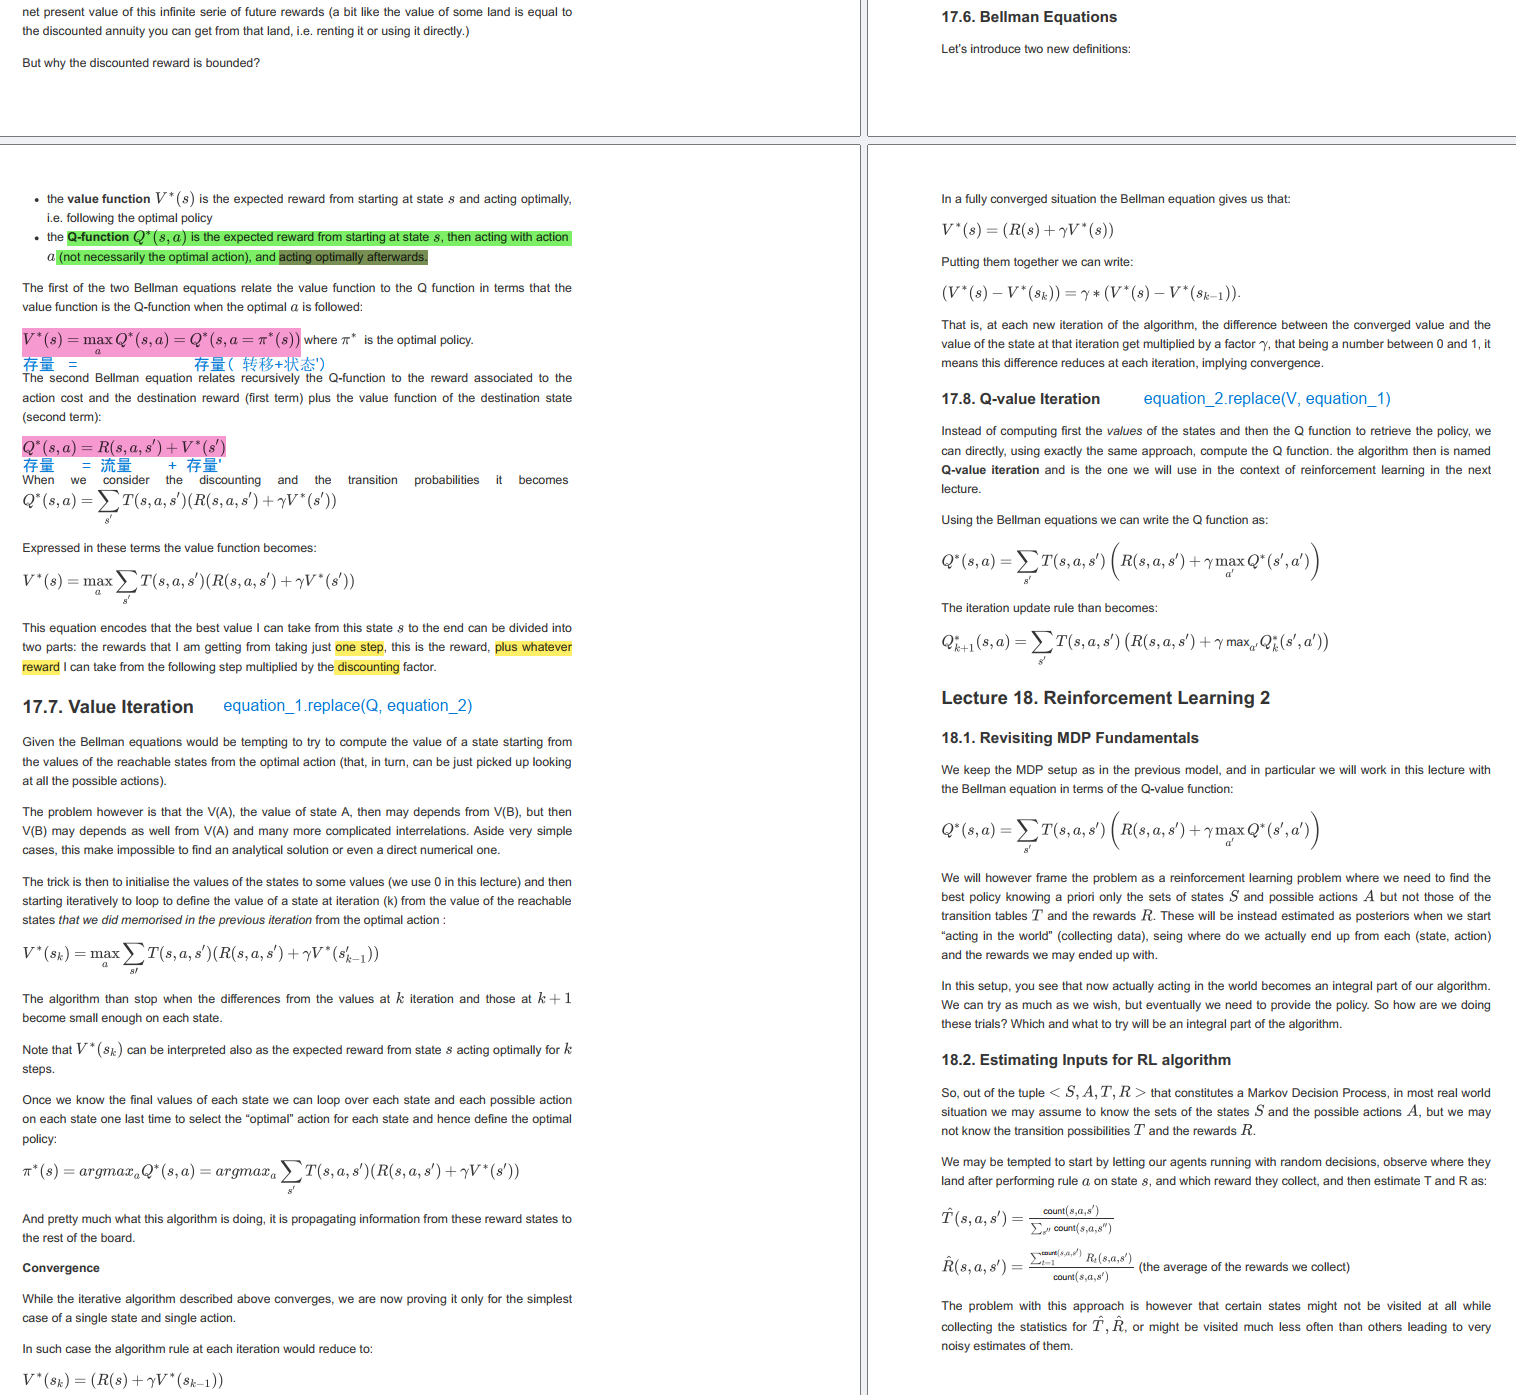

#### 4.2. 悬崖漫步环境

|0|1|2|3|4|5|6|7|8|9|10|11|
|-|-|-|-|-|-|-|-|-|-|-|-|
|12|13|14|15|16|17|18|19|20|21|22|23|
|24|25|26|27|28|29|30|31|32|33|34|35|
|36|37|38|39|40|41|42|43|44|45|46|47|

In [8]:
import copy


class CliffWalkingEnv:
    """ 悬崖漫步环境"""

    def __init__(self, ncol=12, nrow=4):
        self.ncol = ncol  # 定义网格世界的列
        self.nrow = nrow  # 定义网格世界的行
        # 转移矩阵P[state][action] = [(p, next_state, reward, done)]包含下一个状态和奖励
        self.P = self.createP()

    def createP(self):
        # 初始化
        P = [[[] for j in range(4)] for i in range(self.nrow * self.ncol)]  # 48*4
        # 4种动作, change[0]:上,change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        for r in range(self.nrow):
            for c in range(self.ncol):
                s = r * self.ncol + c  ##  当前状态
                for a in range(4):
                    #   位置在悬崖或者目标状态,因为无法继续交互,任何动作奖励都为0
                    ##  最后一行是悬崖的，处在悬崖是不可能的，所以可以任意初始化 
                    if r == self.nrow - 1 and c > 0:
                        P[s][a] = [(1, s, 0, True)]
                        continue
                    # 其他位置
                    ## 其他地方的下个状态，或者说下个x坐标，都要满足在格子内部，若是可能移动到网格的外部，下一步就保持不动
                    c_ = min(self.ncol - 1, max(0, c + change[a][0]))  # 限制在0~11之间
                    r_ = min(self.nrow - 1, max(0, r + change[a][1]))  # 限制在0~3之间
                    s_ = r_ * self.ncol + c_  ##  下个状态的数组地址
                    reward = -1  ## 奖励值初始化到 -1
                    done = False  ##  默认没有达到终止条件（下个坐标在悬崖，或者在终点）
                    # 下一个位置在悬崖或者终点
                    if r_ == self.nrow - 1 and c_ > 0:  ## 最后一行是悬崖的
                        if c_ != self.ncol - 1:  # 下一个位置在悬崖
                            reward = -100  ## 下个坐标是悬崖，奖励是-100
                        done = True  ## 达到了终止条件
                    ##  对给定的动作a，下一步的转移到s_概率是1，reward是动作奖励，done表示是否终止
                    P[s][a] = [(1, s_, reward, done)]
        # print(f'P:{P}')
        return P

#### 4.3. 策略迭代算法（Value Iteration）

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

In [9]:
class BaseIteration:
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.theta = theta  # 策略评估收敛阈值
        self.gamma = gamma  # 折扣因子
        # 价值迭代结束后得到的策略
        self.pi = [None for i in range(self.env.ncol * self.env.nrow)]

    def policy_improvement(self):
        '''
        策略提升：基于v，更新pi
        '''
        for s in range(self.env.nrow * self.env.ncol):  ##  遍历所有的状态
            qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
            for a in range(4):  ##  遍历所有的动作，上下左右这几个方向
                qsa = 0  ##  动作价值初始化到0
                ## 遍历（s,a）对应的s转移可能，拿到T（s,a,s'）、s'、动作的奖励r、是否终止的
                ## 此处对应的self.env.P[s][a]的长度都是1（1个4元组），也就是执行某个动作以后，该动作只能转移到某个确定的状态，不能按T转移到多个状态
                for res in self.env.P[s][a]:
                    p, s_, r, done = res  ## 状态转移概率此处=1、下个状态、动作的奖励r(该循环内不变)、是否终止的
                    qsa += p * (r + self.gamma * self.v[s_] * (1 - done))
                qsa_list.append(qsa)  ## 和策略评估相比较，少了状态动作选择的概率也就是没有策略了，此时选择每个动作的概率都是1
            # 可能多个动作价值Q(s,a)并列第一，第一均分概率，其他动作概率为0
            maxq = max(qsa_list)  ## 拿到这几个动作内最大的价值
            cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
        print("策略提升完成")
        return self.pi

In [10]:
class PolicyIteration(BaseIteration):
    """ 策略迭代算法 Q-value Iteration """

    def __init__(self, env, theta, gamma):
        super().__init__(env, theta, gamma)
        self.pi = [[0.25, 0.25, 0.25, 0.25] for i in range(self.env.ncol * self.env.nrow)]  # 初始化为均匀随机策略  

    def policy_evaluation(self):
        '''
        策略评估Q_value evaluation：基于v、pi，计算状态价值函数v
        '''
        cnt = 0  # 计数器
        max_diff = self.theta + 1
        while max_diff > self.theta:  ## 不断循环，直到old价值函数和new价值函数的绝对值差值很小了，< 给定的很小值 self.theta
            max_diff = 0
            v_ = [0] * self.env.ncol * self.env.nrow  ##  状态价值函数的列表
            for s in range(self.env.ncol * self.env.nrow):  ##  遍历所有的状态
                qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
                for a in range(4):  ##  遍历所有的动作，上下左右这几个方向
                    qsa = 0  ##  动作价值初始化到0
                    ## 遍历（s,a）对应的s转移可能，拿到T（s,a,s'）、s'、动作的奖励r、是否终止的
                    ## 此处对应的self.env.P[s][a]的长度都是1（1个4元组），也就是执行某个动作以后，该动作只能转移到某个确定的状态，不能按T转移到多个状态
                    for res in self.env.P[s][a]:
                        p, s_, r, done = res  ## 状态转移概率此处=1、下个状态、动作的奖励r(该循环内不变)、是否终止的
                        qsa += p * (r + self.gamma * self.v[s_] * (1 - done))  # 奖励和下一个状态有关,所以需要和状态转移概率相乘
                    qsa_list.append(self.pi[s][a] * qsa)  ##  还有一个选择动作的可能性 self.pi，每个动作的pi，对应公式贝尔曼期望方程最开始的累加部分
                ##  累加动作价值，得到状态价值，赋值到 new 价值函数的，也就是贝尔曼期望方程最开始的累加部分
                v_[s] = sum(qsa_list)  # 状态价值函数和动作价值函数之间的关系
                max_diff = max(max_diff, abs(v_[s] - self.v[s]))  ##  old价值函数和new价值函数的绝对值差值
            self.v = v_  ##  复制new价值函数给old价值函数
            cnt += 1
        print(f'策略评估进行{cnt}轮后完成')

    def policy_iteration(self):  # 策略迭代
        while True:
            self.policy_evaluation()  ## 策略评估函数
            old_pi = copy.deepcopy(self.pi)  # 将列表进行深拷贝,方便接下来进行比较
            new_pi = self.policy_improvement()  ##  策略提升函数
            if old_pi == new_pi: break  ##  策略不变了就可以停止迭代

In [11]:
def print_agent(agent, action_meaning, disaster=[], end=[]):
    print("状态价值：")
    for r in range(agent.env.nrow):
        for c in range(agent.env.ncol):
            s = r * agent.env.ncol + c
            # 为了输出美观,保持输出6个字符
            print(f'{agent.v[s]:6.3f}', end=' ')
        print()

    print("策略：")
    for r in range(agent.env.nrow):
        for c in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            s = r * agent.env.ncol + c
            if s in disaster:
                print('****', end=' ')
            elif s in end:  # 目标状态
                print('EEEE', end=' ')
            else:
                a = agent.pi[s]
                pi_str = ''
                for i, v in enumerate(action_meaning):
                    pi_str += v if a[i] > 0 else 'o'
                print(pi_str, end=' ')
        print()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 策略评估进行60轮后完成
# 策略提升完成
# 策略评估进行72轮后完成
# 策略提升完成
# 策略评估进行44轮后完成
# 策略提升完成
# 策略评估进行12轮后完成
# 策略提升完成
# 策略评估进行1轮后完成
# 策略提升完成
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

策略评估进行60轮后完成
策略提升完成
策略评估进行72轮后完成
策略提升完成
策略评估进行44轮后完成
策略提升完成
策略评估进行12轮后完成
策略提升完成
策略评估进行1轮后完成
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


#### 4.4. 价值迭代算法

In [12]:
class ValueIteration(BaseIteration):
    """ 价值迭代算法 Value Iteration"""

    def value_evaluation(self):
        '''
        价值迭代：基于v、最佳a，更新v
        '''
        cnt = 0
        max_diff = self.theta + 1
        while max_diff > self.theta:
            max_diff = 0
            v_ = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = []
                for a in range(4):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        p, s_, r, done = res
                        qsa += p * (r + self.gamma * self.v[s_] * (1 - done))
                    ## 和策略评估相比较，少了状态动作选择的概率也就是没有策略了，此时选择每个动作的概率都是1
                    qsa_list.append(qsa)  # 这一行和下一行代码是价值迭代和策略迭代的主要区别
                v_[s] = max(qsa_list)  ## 拿到这几个动作内最大的价值
                max_diff = max(max_diff, abs(v_[s] - self.v[s]))
            self.v = v_
            if max_diff < self.theta: break
            cnt += 1
        print(f'价值迭代一共进行{cnt}轮')

    def value_iteration(self):
        self.value_evaluation()
        self.policy_improvement()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 价值迭代一共进行14轮
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

价值迭代一共进行14轮
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


#### 4.5. 冰湖环境

在每一个状态都可以采取上、下、左、右 4 个动作。由于智能体在冰面行走，因此每次行走都有一定的概率滑行到附近的其它状态，并且到达冰洞或目标状态时行走会提前结束。每一步行走的奖励是 0，到达目标的奖励是 1。

|0|1|2|3| - |S|F|F|F|
|-|-|-|-|-|-|-|-|-|
|4|5|6|7|   |F|H|F|H|
|8|9|10|11|   |F|F|F|H|
|12|13|14|15|   |H|F|F|G|

In [13]:
import gymnasium as gym

env = gym.make("FrozenLake-v1", render_mode='human')  # 创建环境
_ = env.reset(seed=0)
env = env.unwrapped  # 解封装才能访问状态转移矩阵P
# env.render()  # 环境渲染,通常是弹窗显示或打印出可视化的环境

holes = set()
ends = set()
for s in env.P:  ##  遍历环境的所有状态
    for a in env.P[s]:  ##  遍历状态下所有的动作
        for s_ in env.P[s][a]:  ##  遍历每个动作对应的转移情况
            if s_[2] == 1.0:  # 获得奖励为1,代表是目标
                ends.add(s_[1])  ##  终止标号的呢
            if s_[3] == True:  ##  是否洞
                holes.add(s_[1])  ## 标号
holes = holes - ends
print(f'冰洞的索引: {holes}')
print(f'目标的索引: {ends}')

## 共有三个动作的，每个动作有三种转移可能
## 每个动作都有三种状态转移的可能，和上面的悬崖有些区别的，上面的悬崖只有一种可能
## 导致这种情况的reason，就是冰面太滑了，可能滑到其他地方去了
for a in env.P[14]:  # 查看目标左边一格的状态转移信息
    print(f'动作{a}的状态转移概率：{env.P[14][a]}')


# SFFF
# FHFH
# FFFH
# HFFG
# 冰洞的索引: {11, 12, 5, 7}
# 目标的索引: {15}
# [(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False),
#  (0.3333333333333333, 14, 0.0, False)]
# [(0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False),
#  (0.3333333333333333, 15, 1.0, True)]
# [(0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True),
#  (0.3333333333333333, 10, 0.0, False)]
# [(0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False),
#  (0.3333333333333333, 13, 0.0, False)]

冰洞的索引: {11, 12, 5, 7}
目标的索引: {15}
动作0的状态转移概率：[(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False)]
动作1的状态转移概率：[(0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True)]
动作2的状态转移概率：[(0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False)]
动作3的状态转移概率：[(0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False)]


In [14]:
# 这个动作意义是Gym库针对冰湖环境事先规定好的
action_meaning = ['<', 'v', '>', '^']  ## 上下左右的标识符
theta = 1e-5  ## 当绝对值差值小于阀值时，停止迭代的呢
gamma = 0.9  ## γ值
agent = PolicyIteration(env, theta, gamma)  ## 实例化策略迭代
agent.policy_iteration()  ## 迭代
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])  ## 输出

# 策略评估进行25轮后完成
# 策略提升完成
# 策略评估进行58轮后完成
# 策略提升完成
# 状态价值：
#  0.069  0.061  0.074  0.056
#  0.092  0.000  0.112  0.000
#  0.145  0.247  0.300  0.000
#  0.000  0.380  0.639  0.000
# 策略：
# <ooo ooo^ <ooo ooo^
# <ooo **** <o>o ****
# ooo^ ovoo <ooo ****
# **** oo>o ovoo EEEE

策略评估进行25轮后完成
策略提升完成
策略评估进行58轮后完成
策略提升完成
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


In [15]:
agent = ValueIteration(env, theta, gamma)  ## 实例化价值迭代
agent.value_iteration()  ## 迭代
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])  ## 输出

# 价值迭代一共进行60轮
# 状态价值：
#  0.069  0.061  0.074  0.056
#  0.092  0.000  0.112  0.000
#  0.145  0.247  0.300  0.000
#  0.000  0.380  0.639  0.000
# 策略：
# <ooo ooo^ <ooo ooo^
# <ooo **** <o>o ****
# ooo^ ovoo <ooo ****
# **** oo>o ovoo EEEE

价值迭代一共进行60轮
策略提升完成
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


In [16]:
# import gym
# env = gym.make('LunarLander-v2',render_mode='human')
# obs, info = env.reset(seed=42)
# 
# def policy(observation):
#     return env.action_space.sample()  # Randomly sample an action
# 
# for _ in range(100):
#     action = policy(obs)
#     obs, reward, done, truc, info = env.step(action)
# 
#     if done or truc:
#         obs, info = env.reset()
# 
# env.close()

#### 4.7. Convergence 收敛性证明

- **Value Iteration**:
$$
\begin{align*}
V^*(s_k) &= (R(s) + \gamma V^*(s_{k-1}))\\
\text{and Bellman equations} \\
V^*(s) &= R(s) + \gamma V^*(s')\\
\text{then} \\
(V^*(s) - V^*(s_k)) &= \gamma (V^*(s') - V^*(s_{k-1}))\\
\end{align*}
$$

- **Policy Iteration**:
$$
U \leq \frac{R_{max}}{1-\gamma}
$$

### 5. 时序差分算法

#### 5.1. 简介

在数据分布未知的情况下针对具体的数据点来对模型做出更新的。对于大部分强化学习现实场景（例如电子游戏或者一些复杂物理环境），其马尔可夫决策过程的状态转移概率是无法写出来的，也就无法直接进行动态规划。在这种情况下，智能体只能和环境进行交互，通过采样到的数据来学习，这类学习方法统称为**无模型的强化学习（model-free reinforcement learning）**。

不需要事先知道环境的奖励函数和状态转移函数，而是直接使用和环境交互的过程中采样到的数据来学习，这使得它可以被应用到一些简单的实际场景中。本章将要讲解无模型的强化学习中的两大经典算法：Sarsa 和 Q-learning，它们都是基于**时序差分（temporal difference，TD）**的强化学习算法。

#### 5.2. 时序差分方法

$$
\begin{align*}
Q_{i+1}(s,a) &= (1-\alpha)Q_i(s,a) + \alpha \operatorname{sample}_i(s,a)\\
&= Q_i(s,a) + \alpha (\operatorname{sample}_i(s,a) - Q_i(s,a))\\
&= Q_i(s,a) + \alpha ((R(s,a,s^{\prime}_i) + \gamma \max_{a^{\prime}} Q_i(s^{\prime}_i,a^{\prime})) - Q_i(s,a))\\
&= Q_i(s,a) + \alpha \delta_i
\end{align*}
$$

Attention that here $Q_i(s,a)$ is not the Q-value of the sample i, but the average Q-value up to the sample i including. It already embed all the experience up to sample i.

#### 5.3. Sarsa 算法

在不知道奖励函数和状态转移函数的情况下进行**策略提升**：用时序差分算法来估计动作价值函数$Q$

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))\\
\pi(a|s) = \operatorname{argmax}_a Q(s,a)            ?\\
\pi(a|s) = \begin{cases}
1-\epsilon+\frac{\epsilon}{|A(s)|} &, a = \operatorname{argmax}_a Q(s,a)\\
\frac{\epsilon}{|A(s)|} &, \text{otherwise}
\end{cases}
$




In [17]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库

'''
悬崖环境包括了以下几个功能：
. 初始化网格内容
. step前进一步的，给出下一步的状态、奖励和是否终止的
. reset重置环境的
'''


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow  ## 网格行
        self.ncol = ncol  ## 网格列
        self.c = 0  # 记录当前智能体位置的横坐标
        self.r = self.nrow - 1  # 记录当前智能体位置的纵坐标

    ## step 前进一步的，拿到下一个状态，对应的奖励
    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]  ## 动作
        self.c = min(self.ncol - 1, max(0, self.c + change[action][0]))  ## 下一个状态x到了网格外部，就保持不动的
        self.r = min(self.nrow - 1, max(0, self.r + change[action][1]))  ## 下一个状态y到了网格外部，就保持不动的
        next_state = self.r * self.ncol + self.c  ## 下一个状态的坐标
        reward = -1  ## 默认的奖励都是 -1
        done = False  ## 是否终止了的
        if self.r == self.nrow - 1 and self.c > 0:  # 下一个位置在悬崖或者目标
            done = True  ## 终止
            if self.c != self.ncol - 1:  ## 下一个目标是悬崖，奖励= -100
                reward = -100
        return next_state, reward, done  ## 依次返回了  下一个状态、奖励、是否终止的

    ## 重置到起始点
    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.c = 0
        self.r = self.nrow - 1
        return self.r * self.ncol + self.c  ## reset以后起始的坐标

In [18]:
'''
Sarsa可以看作是一个智能体的，包括了以下几个功能的：
. 使用ε-贪心策略来采取行动，也就是选择一个行动的
. 输出，输出每个状态最优的动作
. update，增量更新动作的价值函数
'''


class Sarsa:
    """ Sarsa算法 """

    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n=1):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.n = n  # 采用n步Sarsa算法

    ## 获取当前采取的行动，采取了ε-贪婪策略
    def take_action(self, s):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:  ##  随机选择一个动作
            a = np.random.randint(self.n_action)
        else:
            a = np.argmax(self.Q_table[s])  ##  拿到动作价值最大的动作
        return a

    ## 拿到每个状态最优的动作，最优动作标记1，其他的动作标记0
    def best_action(self, s):  # 用于打印策略
        Q_max = np.max(self.Q_table[s])
        a_n = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[s, i] == Q_max:
                a_n[i] = 1
        return a_n

    ## 增量更新动作价值函数，对应相应的公式
    def update(self, s0, a0, r, s1, a1, done):
        '''
        基于Q、r、Q‘(a')，更新Q
        '''
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]  ## 算时序差分的
        self.Q_table[s0, a0] += self.alpha * td_error  ##  更新动作价值函数

##### 5.3.1. 基于类Sarsa的悬崖环境实验

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3443.49it/s, episode=500.0, return=-18.900]


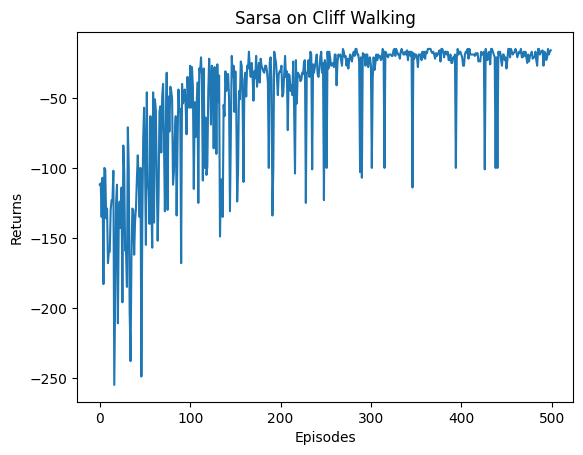

([-112,
  -111,
  -135,
  -107,
  -183,
  -100,
  -101,
  -136,
  -129,
  -168,
  -160,
  -160,
  -130,
  -123,
  -123,
  -102,
  -255,
  -188,
  -125,
  -112,
  -211,
  -135,
  -124,
  -143,
  -114,
  -196,
  -84,
  -103,
  -159,
  -160,
  -185,
  -71,
  -99,
  -202,
  -238,
  -165,
  -129,
  -130,
  -162,
  -138,
  -129,
  -108,
  -91,
  -108,
  -135,
  -100,
  -249,
  -138,
  -79,
  -57,
  -94,
  -155,
  -46,
  -109,
  -116,
  -140,
  -63,
  -128,
  -157,
  -46,
  -139,
  -51,
  -59,
  -103,
  -152,
  -120,
  -60,
  -56,
  -89,
  -49,
  -40,
  -81,
  -131,
  -78,
  -32,
  -130,
  -49,
  -74,
  -42,
  -45,
  -51,
  -112,
  -103,
  -77,
  -63,
  -134,
  -83,
  -44,
  -60,
  -58,
  -168,
  -40,
  -54,
  -50,
  -44,
  -56,
  -76,
  -35,
  -50,
  -57,
  -27,
  -57,
  -28,
  -42,
  -115,
  -53,
  -78,
  -58,
  -39,
  -125,
  -29,
  -31,
  -21,
  -41,
  -109,
  -29,
  -100,
  -64,
  -105,
  -99,
  -46,
  -22,
  -37,
  -69,
  -27,
  -32,
  -86,
  -28,
  -32,
  -90,
  -26,
  -53,
  -34,
  -1

In [41]:
ncol = 12  ##  列
nrow = 4  ##  行
env = CliffWalkingEnv(ncol, nrow)  ##  实例化悬崖环境 env
epsilon = 0.1  ##  ε的值指定是 0.1
alpha = 0.1  ##  α的值初始化是 0.1
gamma = 0.9  ##  γ的值初始化是 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)  ##  实例化sarsa


def plot_agent(agent, num_episodes=500, show=True, reset_seed=True):  # 智能体在环境中运行的序列的数量
    if reset_seed:
        np.random.seed(0)  # 注意每次生成随机数，过程一定，但依次取。因此每次运行函数需要重新设置。
    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=num_episodes // 10, desc=f'Iteration {i}') as pbar:
            for i_episode in range(num_episodes // 10):  # 每个进度条的序列数
                episode_return = 0  ##  序列返回值
                s = env.reset()  ##  初始化环境，并给出初始状态 s
                if 'Sarsa' in agent.__class__.__name__:  ##  如果是sarsa的话
                    a = agent.take_action(s)  ##  智能体采取动作，拿到初始动作actioin
                done = False  ##  是否终止的
                while not done:  ##  没有终止就执行
                    if 'Sarsa' not in agent.__class__.__name__:
                        a = agent.take_action(s)  ##  智能体采取动作，拿到初始动作actioin
                    s_, r, done = env.step(a)  ## 智能体前进一步，拿到下一个状态、奖励，是否终止的
                    # 累加回报
                    episode_return += r  # 这里回报的计算不进行折扣因子衰减
                    # 更新状态和动作
                    if 'Sarsa' in agent.__class__.__name__:
                        a_ = agent.take_action(s_)  ## 智能体使用ε-贪婪策略选择动作 a_ 
                        agent.update(s, a, r, s_, a_, done)  ##  增量更新动作价值函数
                        a = a_  ## 赋值给后续的动作
                    else:
                        # 更新Q表
                        agent.update(s, a, r, s_)
                    s = s_  ## 赋值给当前状态
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                        'return': f'{np.mean(return_list[-10:]):.3f}'
                    })
                pbar.update(1)

    episodes_list = list(range(len(return_list)))
    
    if show:
        plt.plot(episodes_list, return_list)
        plt.xlabel('Episodes')
        plt.ylabel('Returns')
        plt.title(f'{agent.__class__.__name__} on Cliff Walking')
        plt.show()
    
    return return_list, episodes_list


plot_agent(agent)

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1206.19it/s, episode=50,
# return=-119.400]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1379.84it/s, episode=100,
# return=-63.000]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2225.14it/s, episode=150,
# return=-51.200]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2786.80it/s, episode=200,
# return=-48.100]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 1705.21it/s, episode=250,
# return=-35.700]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3393.12it/s, episode=300,
# return=-29.900]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 3694.32it/s, episode=350,
# return=-28.300]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 3705.87it/s, episode=400,
# return=-27.700]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4115.61it/s, episode=450,
# return=-28.500]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3423.20it/s, episode=500,
# return=-18.900]

In [20]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    # print("Q表格：")
    # for r in range(env.nrow):
    #     for c in range(env.ncol):
    #         s = r * env.ncol + c
    #         for a in range(4):
    #             print(f'{s} {action_meaning[a]}: {agent.Q_table[s, a]:6.3f}', end='\t')
    #         print()

    for i in range(env.nrow):
        for j in range(env.ncol):
            s = i * env.ncol + j
            if s in disaster:
                print('****', end=' ')
            elif s in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(s)  ##  拿到这个状态动作价值最大的动作序列，最大的标记1，其他标记0
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


#### 5.4. 多步Sarsa算法

蒙特卡洛方法利用当前状态之后每一步的奖励而不使用任何价值估计，时序差分算法只利用一步奖励和下一个状态的价值估计。

多步时序差分的意思是使用步的奖励，然后使用之后状态的价值估计。

$$
\begin{align*}
Q(s_t,a_t) &\leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))\\
&\leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma r_{t+1} + ... + \gamma^n Q(s_{t+n},a_{t+n}) - Q(s_t,a_t))\\
&\leftarrow Q(s_t,a_t) + \alpha (G_t - Q(s_t,a_t))
\end{align*}
$$

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2854.01it/s, episode=500.0, return=-19.100]


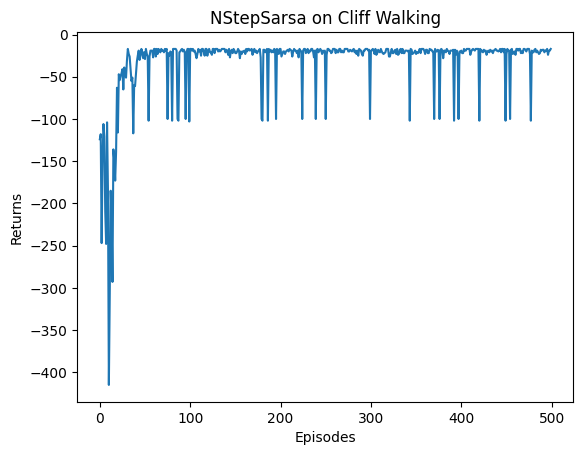

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [21]:
class NStepSarsa(Sarsa):
    """ n步Sarsa算法 """

    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n=1):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action, n)
        self.s_l = []  # 保存之前的状态
        self.a_l = []  # 保存之前的动作
        self.r_l = []  # 保存之前的奖励

    ## 增量更新动作价值函数，对应相应的公式
    ## s0, a0是当前时间步的
    ## r, s1, a1是下一个时间步的，r是奖励，s1是状态，a1是动作
    def update(self, s0, a0, r, s1, a1, done):
        '''        
        基于Q、r、r_、r__、Q'(a')，更新Q
        '''
        self.s_l.append(s0)  ##  当前状态s0加入到状态列表的
        self.a_l.append(a0)  ##  当前动作a0加入到动作列表的
        self.r_l.append(r)  ##  当前状态采取的动作奖励，加入到奖励列表的
        if len(self.s_l) == self.n:  # 若保存的数据可以进行n步更新
            ## 拿到下一个时间步(s1, a1)对应的动作价值函数
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}, a_{t+n})
            ## 逆序遍历奖励列表，算多步Sarsa algorithm公式括号内的非负部分
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.r_l[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                if done and i > 0:
                    s = self.s_l[i]  ## 拿出对应的状态
                    a = self.a_l[i]  ## 对应的动作
                    ## 多步sarsa，增量更新动作价值函数
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            ## 时间步往后移动，最开始的时间步内容需要删除才可以，状态、动作、奖励都需要删除
            ## 需要删除的时间步，也是需要更新的时间步，所以需要使用变量s, a来保存相应的内容以便使用
            s = self.s_l.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新。
            a = self.a_l.pop(0)  # pop(0)是先进先出，pop(-1)是后进先出，默认是-1
            self.r_l.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])  ## 增量更新动作价值函数
        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.s_l = []
            self.a_l = []
            self.r_l = []


n_step = 5  # 5步Sarsa算法
agent = NStepSarsa(ncol, nrow, epsilon, alpha, gamma, n=n_step)

plot_agent(agent)
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])


# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 937.03it/s, episode=50,
# return=-26.500]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 2955.94it/s, episode=100,
# return=-35.200]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2978.95it/s, episode=150,
# return=-20.100]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 3062.61it/s, episode=200,
# return=-27.200]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3172.36it/s, episode=250,
# return=-19.300]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3123.41it/s, episode=300,
# return=-27.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2875.33it/s, episode=350,
# return=-28.000]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 2262.18it/s, episode=400,
# return=-36.500]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 3100.00it/s, episode=450,
# return=-27.000]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3107.54it/s, episode=500,
# return=-19.100]

# 5步Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo
# ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

#### 5.5. Q-learning算法

不同于Sarsa的

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
$

Q-learning的更新公式是

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma \max_{a_{t+1}} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
$

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4157.55it/s, episode=500.0, return=-61.700]


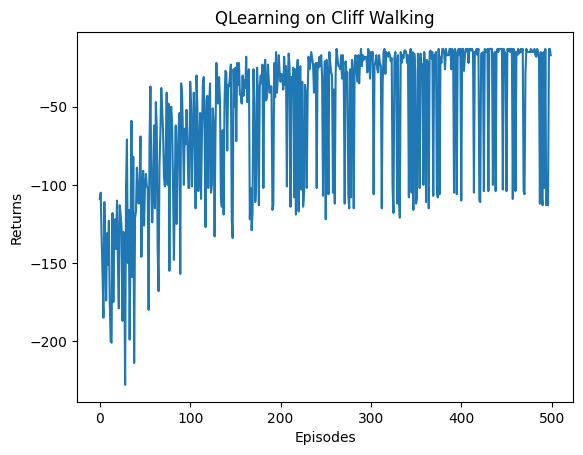

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [22]:
class QLearning(Sarsa):
    """ Q-learning算法 """

    '''
    增量更新动作价值函数，对应相应的Q-learning公式
    和sarsa algorithm不同的地方就是，这使用了状态内所有动作的最大值，但是sarsa直接使用了(s, a)状态动作对的值
    sarsa的公式就是：
    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]    ## 算时序差分的
        self.Q_table[s0, a0] += self.alpha * td_error      ##  更新动作价值函数
    '''
    def update(self, s0, a0, r, s1):
        '''
        基于Q、r、Q‘*，更新Q
        '''
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error


agent = QLearning(ncol, nrow, epsilon, alpha, gamma)

plot_agent(agent)
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1183.69it/s, episode=50,
# return=-105.700]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1358.13it/s, episode=100,
# return=-70.900]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 1433.72it/s, episode=150,
# return=-56.500]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2607.78it/s, episode=200,
# return=-46.500]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3007.19it/s, episode=250,
# return=-40.800]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 2005.77it/s, episode=300,
# return=-20.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2072.14it/s, episode=350,
# return=-45.700]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 4244.04it/s, episode=400,
# return=-32.800]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4670.82it/s, episode=450,
# return=-22.700]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4705.19it/s, episode=500,
# return=-61.700]

# Q-learning算法最终收敛得到的策略为：
# ^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

### 6. Dyna-Q算法

在每次与环境进行交互执行一次 Q-learning 之后，Dyna-Q 会做$n$次 Q-planning。其中 Q-planning 的次数$N$是一个事先可以选择的超参数，当其为 0 时就是普通的 Q-learning。值得注意的是，上述 Dyna-Q 算法是执行在一个离散并且确定的环境中，所以当看到一条经验数据$(s, a, r, s')$时，可以直接对模型做出更新，即$M(s,a)\leftarrow r, s'$。

In [34]:
import random

# 改为从Q-learning继承，减少代码重复
class DynaQ(QLearning):
    """ Dyna-Q算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n=1, n_planning=1):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action, n)
        
        self.n_planning = n_planning  # 执行Q-planning的次数, 对应1次Q-learning
        ## 保存历史交互的数据，也就是智能体和
        self.model = dict()  # 环境模型
        
    def update(self, s0, a0, r, s1):
        ## 智能体和环境交互得到的一个数据，用来update模型的
        super().update(s0, a0, r, s1)     ## 使用 智能体和环境 交互得到的 s0,a0, r, s1 来 update 动作价值函数，也就是学习 Q_table 的。
        ## 保存历史数据，也就是保存智能体和环境一次交互得到的经验数据，用来后续离线训练使用
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中
        ## 通过历史数据来训练 Q_table 动作价值函数，历史数据训练的次数是self.n_planning
        for _ in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            super().update(s, a, r, s_)   ## 使用历史数据来 update Q_table

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3323.98it/s, episode=300.0, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2699.27it/s, episode=300.0, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 414.74it/s, episode=300.0, return=-13.400]


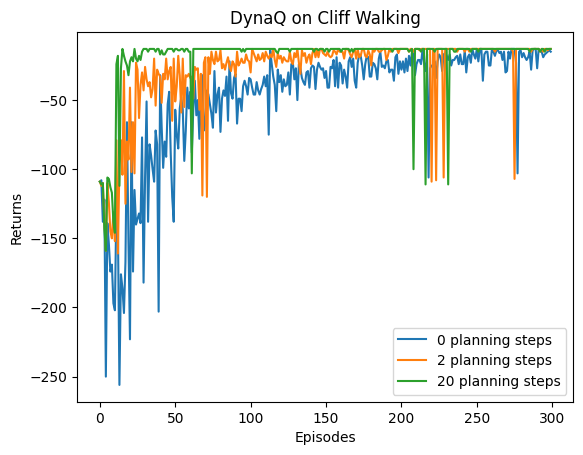

In [45]:
import time
epsilon = 0.01
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]                         ## 使用多少历史经验数据来 update 模型
for n_planning in n_planning_list:
    print(f'Q-planning步数为：{n_planning}')
    time.sleep(0.5)
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning=n_planning)
    return_list, episodes_list = plot_agent(agent, num_episodes=300, show=False, reset_seed=False)
    plt.plot(episodes_list,return_list,label=f'{n_planning} planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'{agent.__class__.__name__} on Cliff Walking')
plt.show()

# Q-planning步数为：0

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 615.42it/s, episode=30,
# return=-138.400]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 1079.50it/s, episode=60,
# return=-64.100]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 1303.35it/s, episode=90,
# return=-46.000]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 1169.51it/s, episode=120,
# return=-38.000]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 1806.96it/s, episode=150,
# return=-28.600]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 2303.21it/s, episode=180,
# return=-25.300]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 2473.64it/s, episode=210,
# return=-23.600]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 2344.37it/s, episode=240,
# return=-20.100]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 1735.84it/s, episode=270,
# return=-17.100]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2827.94it/s, episode=300,
# return=-16.500]

# Q-planning步数为：2

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 425.09it/s, episode=30,
# return=-53.800]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 655.71it/s, episode=60,
# return=-37.100]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 799.69it/s, episode=90,
# return=-23.600]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 915.34it/s, episode=120,
# return=-18.500]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 1120.39it/s, episode=150,
# return=-16.400]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 1437.24it/s, episode=180,
# return=-16.400]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 1366.79it/s, episode=210,
# return=-13.400]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 1457.62it/s, episode=240,
# return=-13.200]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 1743.68it/s, episode=270,
# return=-13.200]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1699.59it/s, episode=300,
# return=-13.500]

# Q-planning步数为：20

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 143.91it/s, episode=30,
# return=-18.500]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 268.53it/s, episode=60,
# return=-13.600]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 274.53it/s, episode=90,
# return=-13.000]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 264.25it/s, episode=120,
# return=-13.500]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 263.58it/s, episode=150,
# return=-13.500]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 245.27it/s, episode=180,
# return=-13.000]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 257.16it/s, episode=210,
# return=-22.000]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 257.08it/s, episode=240,
# return=-23.200]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 261.12it/s, episode=270,
# return=-13.000]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 213.01it/s, episode=300,
# return=-13.400]

## 强化学习进阶篇

### 7. 深度Q网络（DQN）算法